# Durham ExGal N-body Tutorial

*The content in this notebook has been adapted from existing materials, with credit to Shaun Brown and Sownak Bose for the original material*

In this session we are going to explore the uses and parameters for n-body simulations. We will do this by exploring some pre-defined scenarios and experimenting with how our simulation set-up impacts the results.

We will first look at the scenario of two merging NFW dark matter halos. The simulations will begin with an idealised set up, before being evolved as an N-body self gravitating system. 

We will be running these examples using the SWIFT cosmology code. Later in the notebook we will explain how to set up a simulation in SWIFT.

The main goals of this session is to run a basic simulation and start to familiarise ourselves with the process, what technical details are involved and to start to get a feel for what the outputs of these simulations look like. The key aims are:

   - Familiarise ourselves with HDF5 data sets from simulations
   - Run an N-body gravity simulation.
   - Begin to use and visualise the outputs.

Let's begin by importing some modules that will be useful later. These are standard Python libraries and not specific to working with cosmological simulations.

NumPy contains many numerical functions including mathematical functions, random number generators, linear algebra routines, and fourier transforms. Matplotlib is a library which allows us to create plots and visualisations in python. H5py is the python interface to the HDF5 file format.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

# Working with HDF5 files

HDF5 is a file format designed to store and organise large data sets. HDF5 files contain two types of objects:
- datasets (multidimensional arrays)
- groups (container structures which can hold datasets or other groups)

HDF5 files are widely using in cosmological simulations as both inputs and outputs.

We can load a HDF5 file using the `.File` command. We need to provide the file name and what mode we want to open the file in e.g. 'r' for read, 'w' for write, 'a' for append

In [9]:
h = h5.File('SimulationOutputs/dir_isolated_host/output_0000.hdf5','r')

Now we have loaded a file we need to see what groups our file contains. We can access the names of the groups using the `keys()` command.

In [10]:
print(h.keys())

<KeysViewHDF5 ['Cells', 'Code', 'Cosmology', 'DMParticles', 'GravityScheme', 'Header', 'InternalCodeUnits', 'Parameters', 'PartType1', 'PhysicalConstants', 'Policy', 'RecordingTriggers', 'SubgridScheme', 'Units', 'UnusedParameters']>


Here we can see that there are a lot of different groups in the snapshot files. A lot of this is information about the particular simulation run and the model it used. The simulation data itself will generally be in `PartType*`. Where the main particle types are (see the swift documentation for a full list):

- `PartType0`, gas.
- `PartType1`, collisionless dark matter.
- `PartType4`, stars.

Here we have run a DM only simulation, so the data we want is in `PartType1`.

We can now see what information is held in `PartType1`

In [6]:
print(h['PartType1'].keys())

<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Potentials', 'Softenings', 'Velocities']>


Here there are six properties stored for each DM particle (the number will change for each particle type). Here let's have a quick look at the position of the particles to see what our distribution looks like.

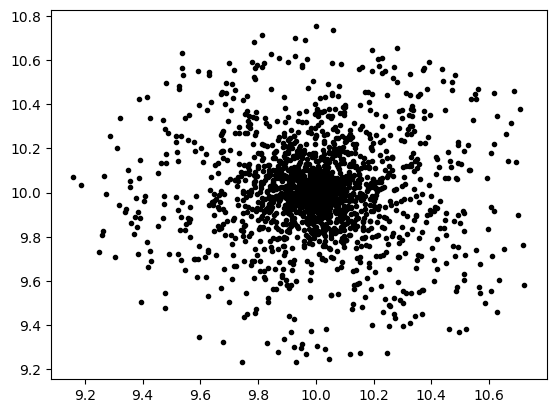

In [7]:
pos = h['PartType1']['Coordinates']
                     
plt.plot(pos[:,0],pos[:,1],'k.')

# Initial conditions

The first thing we need is some initial conditions (ICs) for the three simulations we are about to run. ICs are essentially a list of all of the particle positions and velocities at the start of the simulation we want to run. For this session we have already generated the three ICs we will use, which can be found in the files SimulationOutputs/ICs/ICs_isolate_host.hdf5, SimulationOutputs/ICs/ICs_isolate_satellite.hdf5 and SimulationOutputs/ICs/ICs_merger.hdf5. These have been generated using the Python script SimulationOutputs/ICs/Gen_ICs.py

To start with let's have a quick look at what the ICs look like

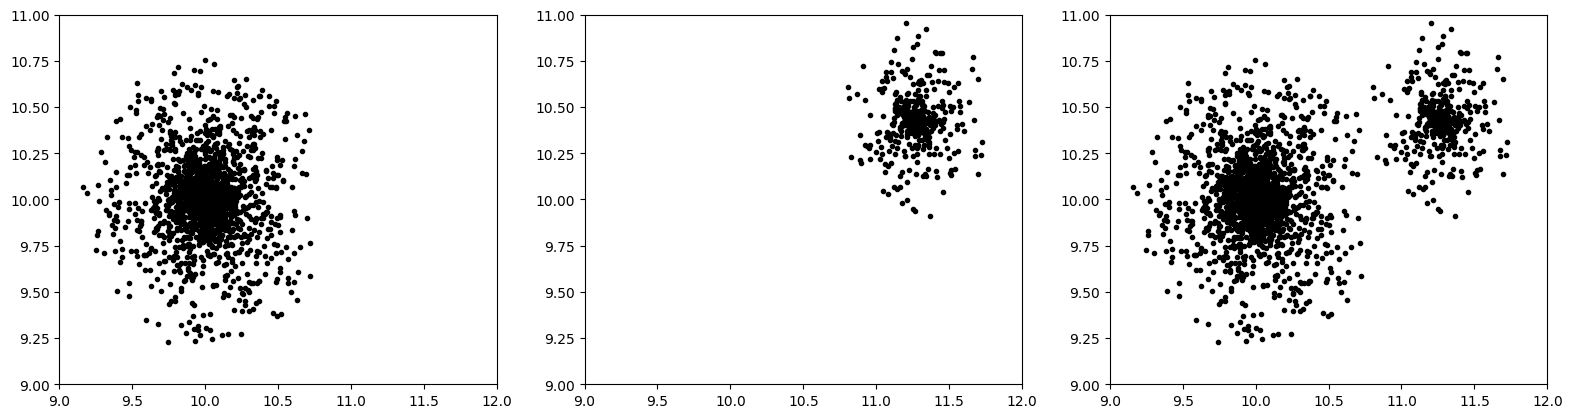

In [11]:
file_names = ['./SimulationOutputs/ICs/ICs_host.hdf5','./SimulationOutputs/ICs/ICs_sat.hdf5','./SimulationOutputs/ICs/ICs_merger.hdf5']

fig, ax = plt.subplots(1,3,figsize=(6.4*3,4.8))
for i in range(3):
    h = h5.File(file_names[i],'r') #read hdf5 file
    pos = h['PartType1/Coordinates']
                
    ax[i].plot(pos[:,0],pos[:,1],'k.')
    ax[i].set_xlim(9,12)
    ax[i].set_ylim(9,11)


The three different ICs represent the host on its own (left), the merging satellite on its own (middle), and the two systems modelled together (right). Both systems are assumed to have NFW profiles, with the host being a $10^{12}$ M$_{\odot}$ mass DM halo, with a concentration of $c=6$. While the merging system is a $10^{11.5}$ M$_{\odot}$ mass halo with a concentration of $c = 15$. In terms of mass these systems are similar to the ongoing merger between our Milky Way and the Large Magellanic cloud.

These simulations use a particle mass of $10^{9}$ M$_{\odot}$, so contain roughly a few thousand particles.

Assuming an NFW profile specifies the averaged positions of the particles. But we must also provide velocities. These are generated so that each system is in equilibrium, according to the Jeans equation. For those interested in how to generate these ICs have a look at the Gen_ICs.py script in the ICs directory.

# Running the simulations

Now that we have generated the initial conditions we can run the simulations. 

In the working directory for this session there is a SWIFT parameter file setup to run the host halo in isolation, `parameter_isolated_host.yml`, with a submission script, `submit.sh`, to set the simulation running. 

You will need to load some modules on the COSMA system for the code to behave correctly. Type the following commands in your command line:
- module load intel_comp/2024.2.0 compiler-rt tbb compiler mpi
- module load ucx/1.17.0
- module load parallel_hdf5/1.14.4
- module load fftw/3.3.10
- module load parmetis/4.0.3-64bit
- module load gsl/2.8 

To run the code we use the command `./submit.sh`. This calls the executable and begins the code. Hopefully, this outputs a bunch of numbers to the command line that summarise how the simulation is progressing, listing information such as the number of time steps, the current time, and the time step being used. The current simulation is set to run for 10 Myr, so will finish when the second column reads 1e-2 in internal units. This will take a few minutes to complete.

The simulations will finish with the line '... main: done. Bye.'. We can then check that the output files look reasonable. Type `ls dir_isolated_host`, this should output a bunch of file that read output_0*.hdhf. These are known as simulation snapshots, and are outputs of all the particles in the simulation and their associated properties over a range of times. Each snapshot is the simulation at a given time, and are chronologically ordered (output_0000.hdf5 is the first snapshot output). Generally, it is too expensive to output the information at every time step, hence we output this at specific times. The number of snapshots for a cosmological simulation typically range from tens to a few hundred.

Now we need to run two more simulations. One with the satellite in isolation, and the more interesting situation where the host and satellite interact. You therefore need to create new parameter files and submission scripts to run these simulations. I.e. you will need to edit the `parameter_isolated_host.yml` and `submit.sh` files. The main things that will need to be changed are the path to IC files, (the parameter InitialConditions: ‘File_name’ under the ‘InitialConditions’ section) as well as output directory so that the simulation we have just ran is not overwritten (the parameters ‘subdir’ under the ‘Snapshots’ section). In this notebook example we are going to output the simulations in the directories `dir_isolated_sat` and `dir_merger`, though any name can be used.

If you have any issues running the code and generating the snapshots we have pre-generated the outputs for you if you want to move straight on to the analysis portion.

## Analysing the simulations

At this stage we would run the simulation. However, we have some pre-run results for you to get hands on with. We will cover running the simulations later in the notebook.

Now that the simulations have been run we can start to analyse the results. Let's start by making sure we can read in the snapshot data. We'll start with the first snapshot output, `ouput_0000.hdf5`, which should be the same as the initial conditions provided.

We can now start to look at the time evolution of the system. We'll start by looking at the two isolated cases to get a feel for the dynamics without them interacting.

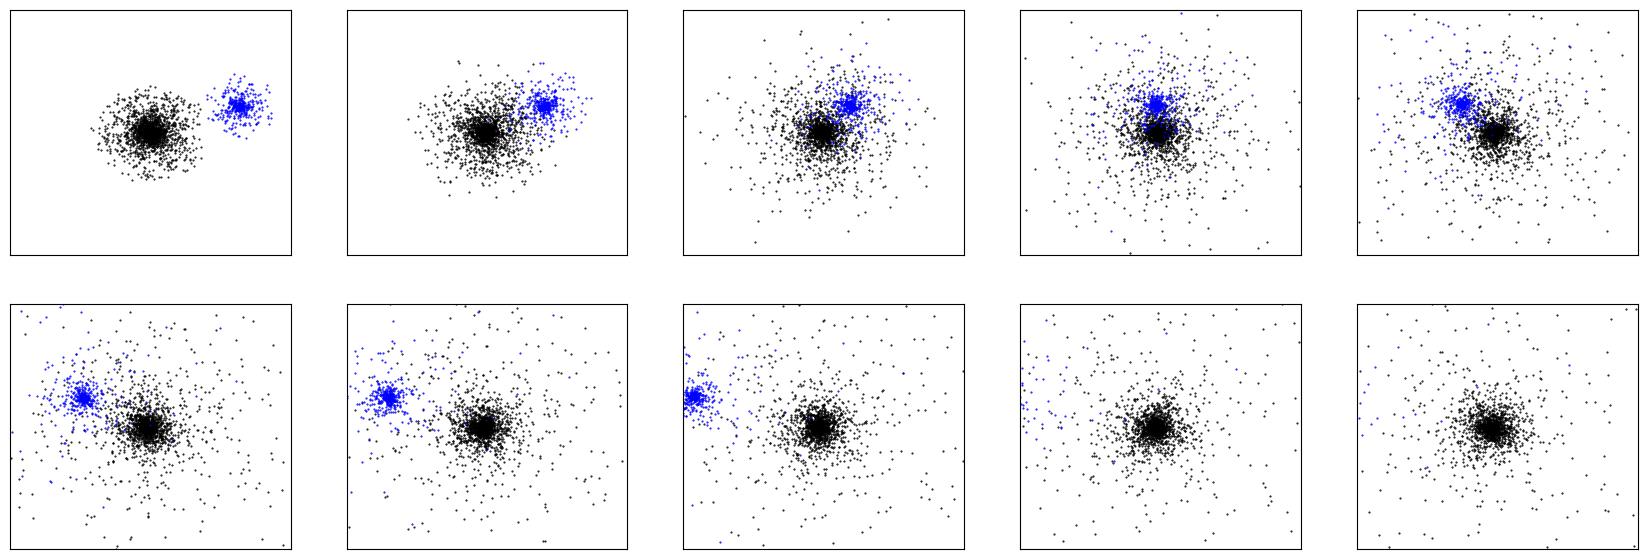

In [13]:
num_snap = 40 #maximum snapshot to use
step = 4      #snapshots to skip 
pos_host = []
pos_sat = []

k = 0
while k<=num_snap:
    h_host = h5.File('SimulationOutputs/dir_isolated_host/output_%04d.hdf5'%k,'r')
    h_sat = h5.File('SimulationOutputs/dir_isolated_sat/output_%04d.hdf5'%k,'r')
    
    pos_host.append(h_host['PartType1']['Coordinates'])
    pos_sat.append(h_sat['PartType1']['Coordinates'])
    k+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        ax[i,j].plot(pos_host[k][:,0],pos_host[k][:,1],'k.',markersize=1)
        ax[i,j].plot(pos_sat[k][:,0],pos_sat[k][:,1],'b.',markersize=1)
        
        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(8,12)
        ax[i,j].set_ylim(8,12)
        k+=1

The set up of the system is for the satellite to fall towards the host, with the collision slightly offset from head on. In this set up where they do not interact they simply fly past each other. The other noticeable feature is that the edges of each halo appear to 'puff up'. Due to the ICs having a sharp cut off in density the system slightly readjusts at the start, with a small number of particles essentially thrown out due to their specific, randomly assigned, velocities. Though the halo as a whole is stable.

Let's now make the same plot but for when the two systems interact. Here we need to be able to identify particles as belonging to the host and the satellite. In the previous plot this was trivial as they were separate simulations. Here we can use the particle IDs to do this. Each particle is assigned a unique ID so that it can be tracked between snapshots. For these particular ICs the Particle IDs are ordered so that the first N particles are the host (in this set up the host has 2074 particles), and the rest belong to the satellite. Hence, where `PaticleIDs<2074` are those belonging to the host and `PaticleIDs>=2074` the satellite.

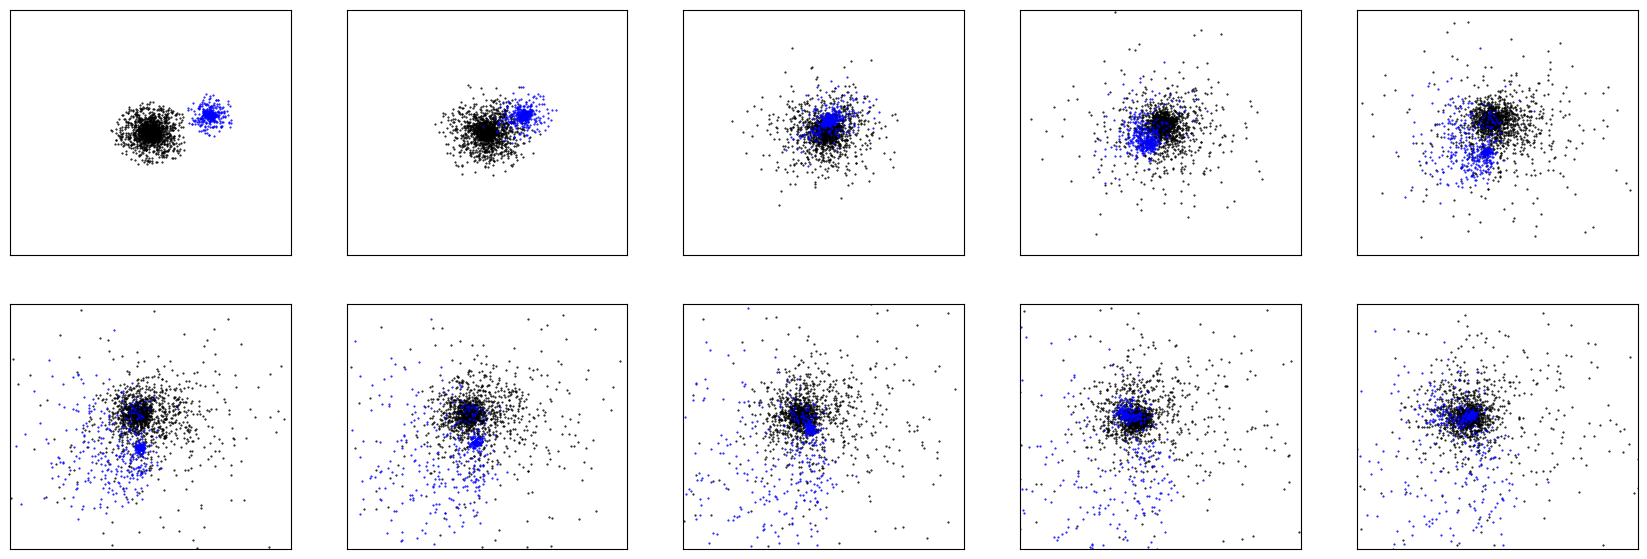

In [15]:
N_host = 2074
num_snap = 40 #maximum snapshot to use
step = 4      #snapshots to skip
pos = []
part_ID = []
k = 0
while k<=num_snap:
    h = h5.File('SimulationOutputs/dir_merger/output_%04d.hdf5'%k,'r')
    
    pos.append(np.array(h.get('PartType1/Coordinates')))
    part_ID.append(np.array(h.get('PartType1/ParticleIDs')))
    k+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        cut_host = part_ID[k]<N_host
        ax[i,j].plot(pos[k][cut_host,0],pos[k][cut_host,1],'k.',markersize=1)
        ax[i,j].plot(pos[k][np.invert(cut_host),0],pos[k][np.invert(cut_host),1],'b.',markersize=1)

        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(7,13)
        ax[i,j].set_ylim(7,13)
        k+=1

Here the two haloes now clearly interact. The satellite initially falls towards the host halo, before being slingshot around and eventually falling back into the host where it is fully merged with the host. You can see how the particles from the satellite become part of the structure of the new overall larger halo.

# Exploring physical parameters in the simulation

There are many parameters in an n-body code which are set by the user and impact how our code runs. Some of these are:
- the softening lengths
- the timestep
- the initial conditions of the simulation

## Softening 
Gravitational softening is a numerical technique where the gravitational force between particles is 'softened' on small scales to prevent the force from going to infinity when particles get very close. This helps us reduce numerical instability and remove unrealistic motions. Softening effectively spreads the mass of the particle allowing simulations to run smoothly. However, our choice of softening length can also impact the results of our simulations

In the above examples the softening is `0.001` which is the Plummer-equivalent softening. However, we could change this value - for instance in the `SimulationOutputs/dir_merger_highsoftening` the same merger scenario has been run with a softening on `0.1` instead. Let's have a look at this scenario.

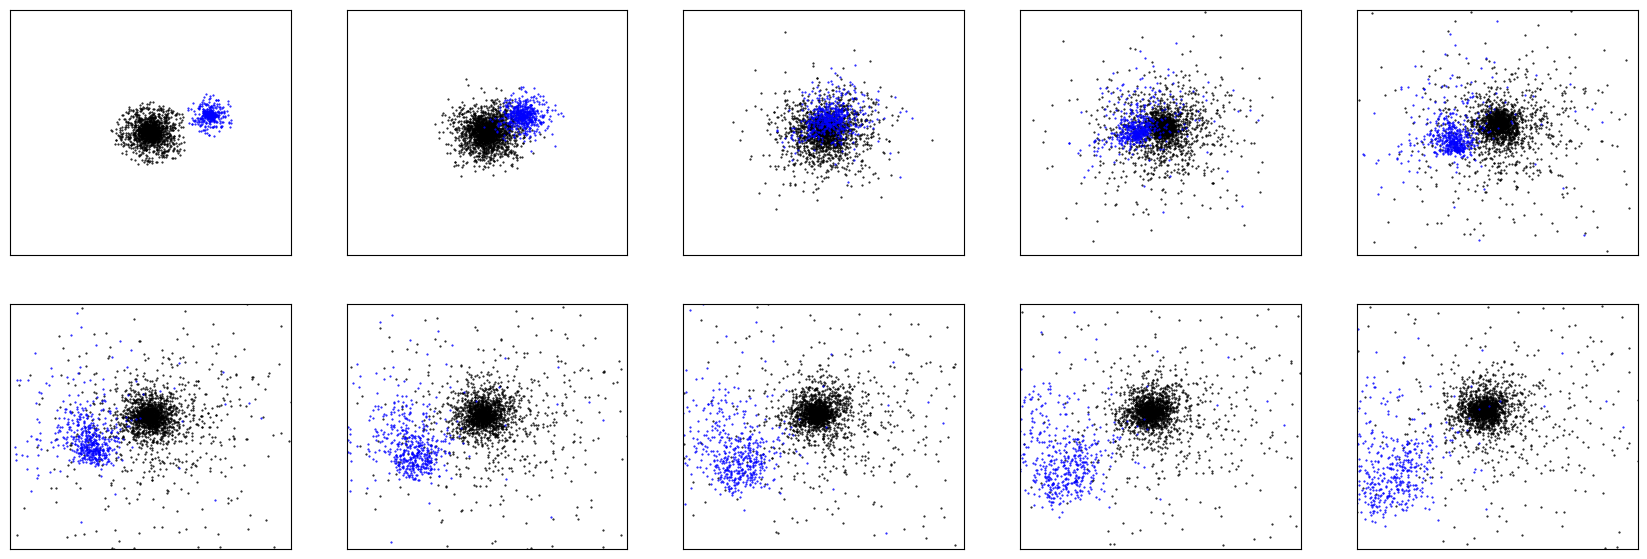

In [18]:
N_host = 2074
num_snap = 40 #maximum snapshot to use
step = 4      #snapshots to skip
pos = []
part_ID = []
k = 0
while k<=num_snap:
    h = h5.File('SimulationOutputs/dir_merger_highsoftening/output_%04d.hdf5'%k,'r')
    
    pos.append(np.array(h.get('PartType1/Coordinates')))
    part_ID.append(np.array(h.get('PartType1/ParticleIDs')))
    k+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        cut_host = part_ID[k]<N_host
        ax[i,j].plot(pos[k][cut_host,0],pos[k][cut_host,1],'k.',markersize=1)
        ax[i,j].plot(pos[k][np.invert(cut_host),0],pos[k][np.invert(cut_host),1],'b.',markersize=1)

        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(7,13)
        ax[i,j].set_ylim(7,13)
        k+=1

Here we can see that the higher softening completely reduces the forces so much that the merger no longer takes place and the satellite is disrupted, but doesn't merge in the same time frame.

While we may choose to change the softening for different scenarios it is important that our choice of value doesn't disrupt the scientific outcome of the system.

**Investigation activity: Can you find the threshold for softening which prevents the halo and satellite from merging? Use the information on how to run the simulations to run the halo merger choosing different values for the softening and investigate how the choice of softening length changes the results of the simulation**

## Timesteps 
In SWIFT we can set the timestep in our code. This is done using the `dt_min` and `dt_max` parameters which set the minimum and maximum possible timestep in the simulations. The code can then choose the size of timestep within this range. If we want a fixed timestep run then we need to set `dt_min = dt_max`.

The choice of timestep impacts the physical operations in our code. Too large a timestep and we risk missing important interactions as particles are kicked past each other. Too small a timestep and our simulation becomes very compute and time intensive. Finding a balanced timestep choice which gives us good results without being overly-detailed is an important consideration.

Our snapshots are output at pre-determined times so the choice of timestep does not impact the frequency of our snapshots. If you want to generate more snapshots you'll also need to edit the `delta_time` parameter in the parameter file.

**Investigation activity: Experiment with different timestep choices and examine their outcomes.** 
- **How long does it take to complete a run with large snapshots vs small snapshots?**
- **What happens if you have a very large timestep? Can you find a timestep choice where the step is so large you miss some of the science?**
- **Are your results improved by very small timesteps? Is there a threshold below which results do not get better and the simulation just takes longer to run?**

## Initial Conditions

Our initial conditions dictate how our system will behave so we can create different scenarios by changing our initial conditions.

There are lots of values we can change when we generate our initial conditions.

**Investigation activity: Try changing the initial conditions of your simulation**
- **Change the satellite infall parameters, both its velocity and impact angle, and see how this affects the merger. You can edit the`Gen_ICs.py` file in the `ICs/` directory, particularly the lines 101 and 102 that set the impact velocity and parameter.**
- **Similarly you could mess around with the properties of the two haloes. How does changing their mass or concentration affect the dynamics? (these are set in line 91 and 92.)**

# INSERT COSMOLOGICAL BOX HERE

# Extension Activities

- Explore the parameter file and see what other quantities you can adjust. For more information on the SWIFT parameter files see this webpage: https://swift.strw.leidenuniv.nl/docs/ParameterFiles/index.html
- Make a movie. Use matplotlib to save plots as a PNG file and use ffmpeg or PIL to combine them into a video or GIF. You could show the process of the halo and satellite merging or the structures forming in your cosmological box.